# Forecasting Time Series with Irregular Timestamps

When working with time series data, the frequency of the timestamps is a crucial factor that can significantly impact the forecasting results. Regular frequencies like daily, weekly, or monthly are straightforward to handle. However, irregular frequencies like business days, which exclude weekends, can be challenging for time series forecasting methods.

Our forecast method is equipped to handle this kind of irregular time series data, as long as you specify the frequency of the series. For example, in the case of business days, the frequency should be passed as 'B'. Without this, the method might fail to automatically detect the frequency, especially when the timestamps are irregular.

In [1]:
#| hide
from nixtla.utils import colab_badge

In [2]:
#| echo: false
colab_badge('docs/tutorials/8_irregular_timestamps')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/8_irregular_timestamps.ipynb)

In [3]:
#| hide
from fastcore.test import test_eq, test_fail, test_warns
from dotenv import load_dotenv

In [4]:
#| hide
load_dotenv()

True

In [5]:
import pandas as pd
from nixtla import NixtlaClient

In [6]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [7]:
#| hide
nixtla_client = NixtlaClient()

The first step is to fetch your time series data. The data must include timestamps and the associated values. For instance, you might be working with stock prices, and your data could look something like the following. In this example we use [`OpenBB`](https://docs.openbb.co/sdk).

In [8]:
#| hide
# test custom frequency
df_fed_test = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/fed.csv')
pd.testing.assert_frame_equal(
    nixtla_client.forecast(df_fed_test, h=12, target_col='FF', level=[90]),
    nixtla_client.forecast(df_fed_test, h=12, target_col='FF', freq='W', level=[90])
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-WED
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-WED
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [9]:
pltr_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/pltr.csv')
pltr_df['date'] = pd.to_datetime(pltr_df['date'])

In [10]:
pltr_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400,0.0,0.0
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600,0.0,0.0
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300,0.0,0.0
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900,0.0,0.0
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000,0.0,0.0


Let's see that this dataset has irregular timestamps. The `dayofweek` attribute from pandas' DatetimeIndex returns the day of the week with Monday=0,...,Sunday=6. So, checking if `dayofweek > 4` is essentially checking if the date falls on a Saturday (5) or Sunday (6), which are typically non-business days (weekends).

In [11]:
(pltr_df['date'].dt.dayofweek > 4).sum()

0

As we can see the timestamp is irregular. Let's inspect the `Close` series.

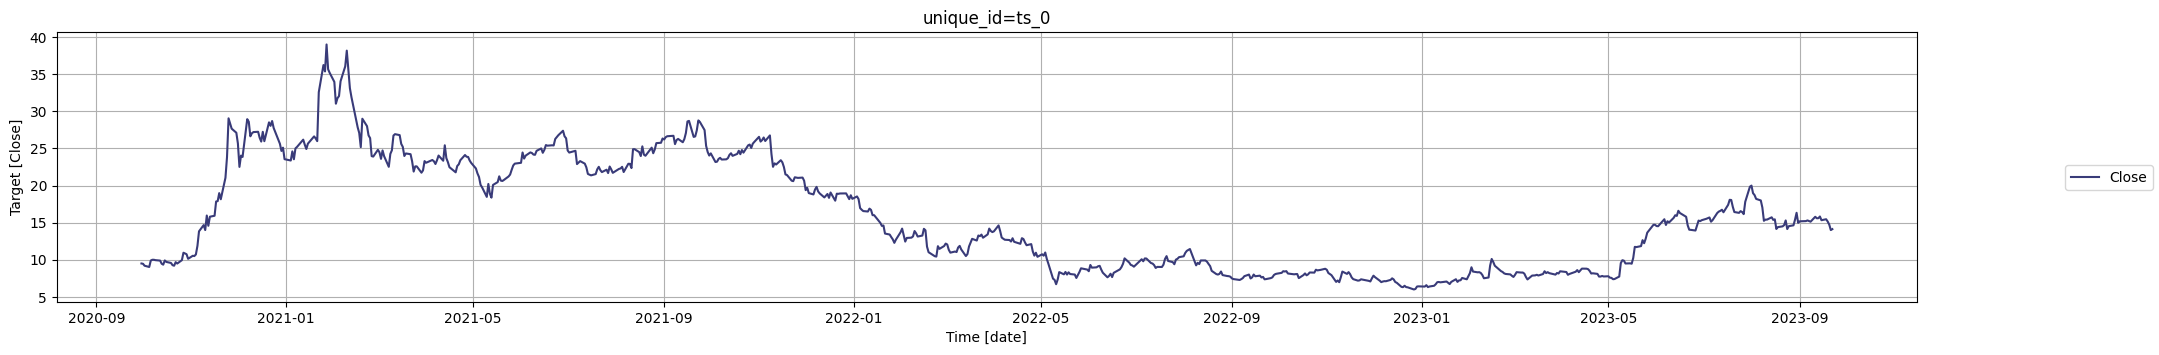

In [12]:
nixtla_client.plot(pltr_df, time_col='date', target_col='Close')

To forecast this data, you can use our `forecast` method. Importantly, remember to specify the frequency of the data using the `freq` argument. In this case, it would be 'B' for business days. We also need to define the `time_col` to select the index of the series (by default is `ds`), and the `target_col` to forecast our target variable, in this case we will forecast `Close`:

In [13]:
#| hide
# fails to infer "B" frequency
test_fail(
    lambda: nixtla_client.forecast(
        df=pltr_df, h=14,
        time_col='date', target_col='Close',
    ),
    contains='frequency'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...


In [14]:
fcst_pltr_df = nixtla_client.forecast(
    df=pltr_df, h=14, freq='B',
    time_col='date', target_col='Close',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [15]:
fcst_pltr_df.head()

,date,TimeGPT
0,2023-09-25,14.688427
1,2023-09-26,14.742798
2,2023-09-27,14.781240
3,2023-09-28,14.824156
4,2023-09-29,14.795214


Remember, for business days, the frequency is 'B'. For other frequencies, you can refer to the pandas offset aliases documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases.

By specifying the frequency, you're helping the forecast method better understand the pattern in your data, resulting in more accurate and reliable forecasts.

Let's plot the forecasts generated by `TimeGPT`.

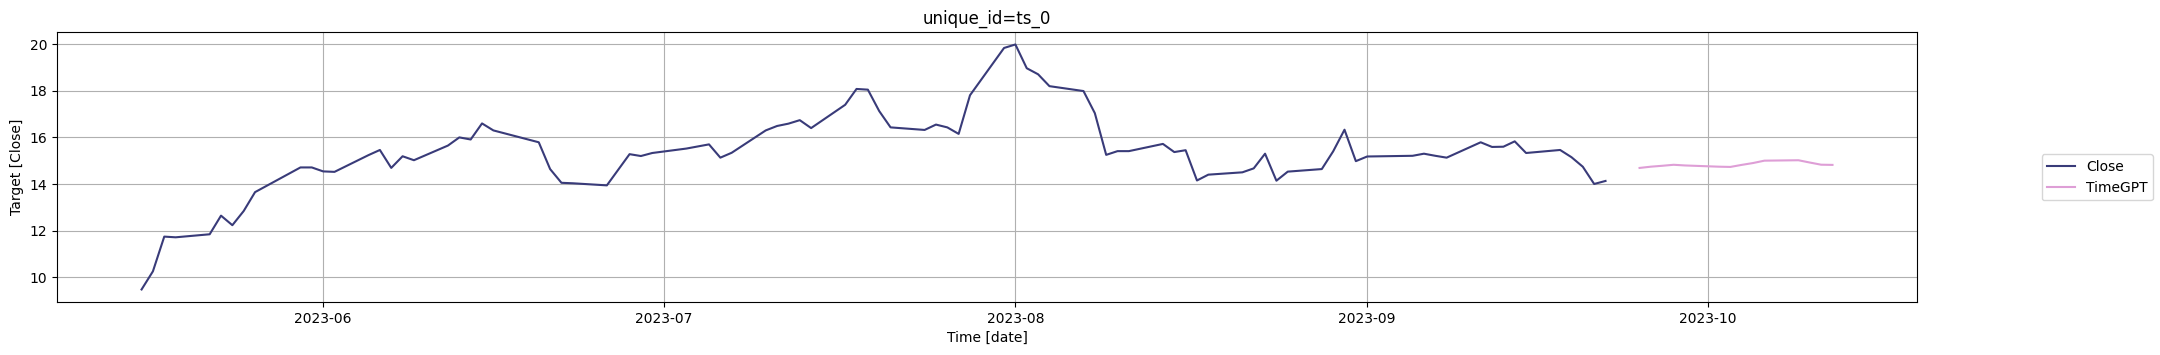

In [16]:
nixtla_client.plot(
    pltr_df, 
    fcst_pltr_df, 
    time_col='date',
    target_col='Close',
    max_insample_length=90, 
)

You can also add uncertainty quantification to your forecasts using the `level` argument:

In [17]:
fcst_pltr_levels_df = nixtla_client.forecast(
    df=pltr_df, h=42, freq='B',
    time_col='date', target_col='Close',
    add_history=True,
    level=[80, 90],
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


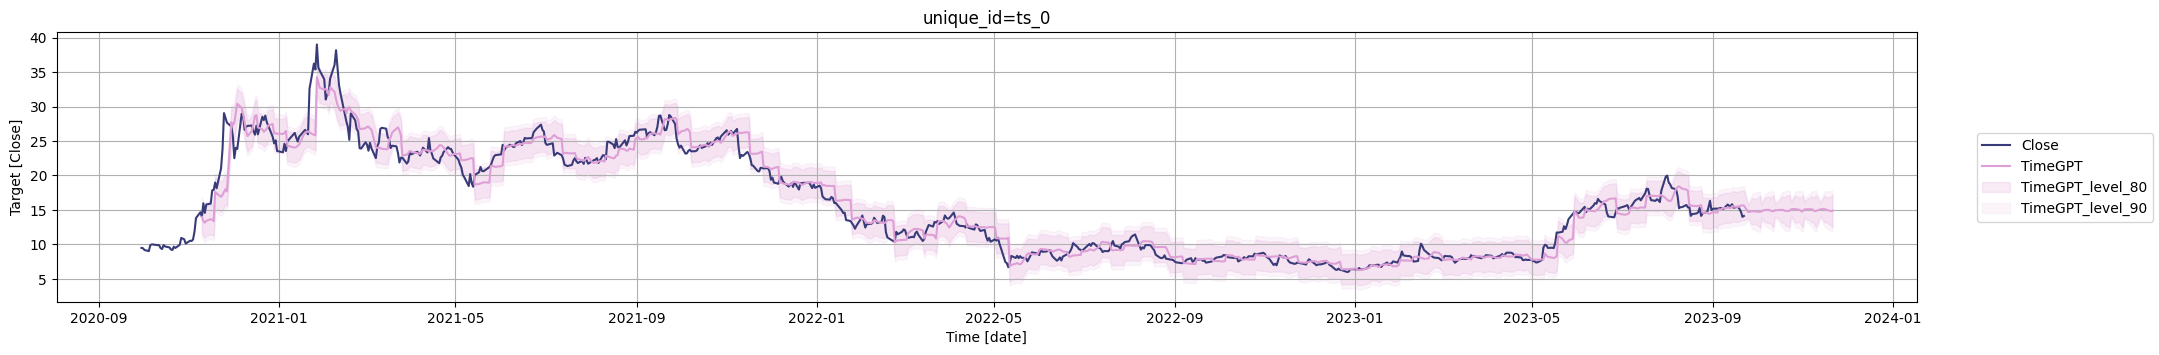

In [18]:
nixtla_client.plot(
    pltr_df, 
    fcst_pltr_levels_df, 
    time_col='date',
    target_col='Close',
    level=[80, 90],
)

If you want to forecast another variable just change the `target_col` parameter. Let's forecast `Volume` now:

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


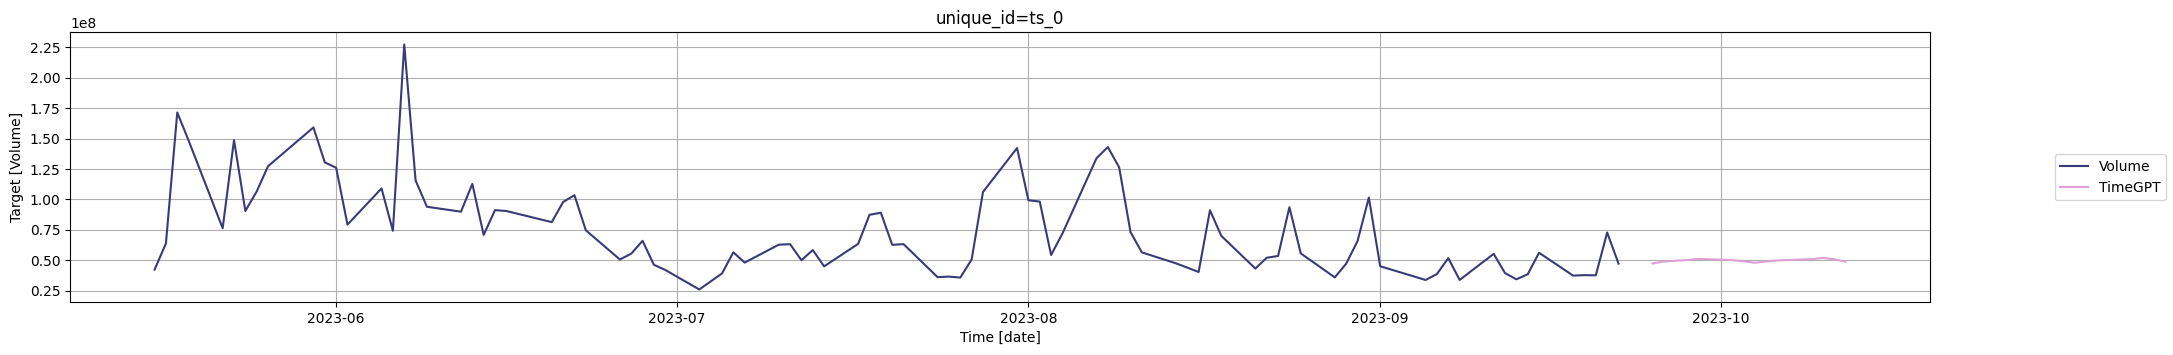

In [19]:
fcst_pltr_df = nixtla_client.forecast(
    df=pltr_df, h=14, freq='B',
    time_col='date', target_col='Volume',
)
nixtla_client.plot(
    pltr_df, 
    fcst_pltr_df, 
    time_col='date',
    max_insample_length=90,
    target_col='Volume',
)

But what if we want to predict all the time series at once? We can do that reshaping our dataframe. Currently, the dataframe is in wide format (each series is a column), but we need to have them in long format (stacked one each other). We can do it with: 

In [20]:
pltr_long_df = pd.melt(
    pltr_df, 
    id_vars=['date'],
    var_name='series_id'
)

In [21]:
pltr_long_df.head()

,date,series_id,value
0,2020-09-30,Open,10.00
1,2020-10-01,Open,9.69
2,2020-10-02,Open,9.06
3,2020-10-05,Open,9.43
4,2020-10-06,Open,9.04


Then we just simply call the `forecast` method specifying the `id_col` parameter.

In [22]:
fcst_pltr_long_df = nixtla_client.forecast(
    df=pltr_long_df, h=14, freq='B',
    id_col='series_id', time_col='date', target_col='value',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [23]:
fcst_pltr_long_df.head()

,series_id,date,TimeGPT
0,Adj Close,2023-09-25,14.688427
1,Adj Close,2023-09-26,14.742798
2,Adj Close,2023-09-27,14.781240
3,Adj Close,2023-09-28,14.824156
4,Adj Close,2023-09-29,14.795214


Then we can forecast the `Open` series:

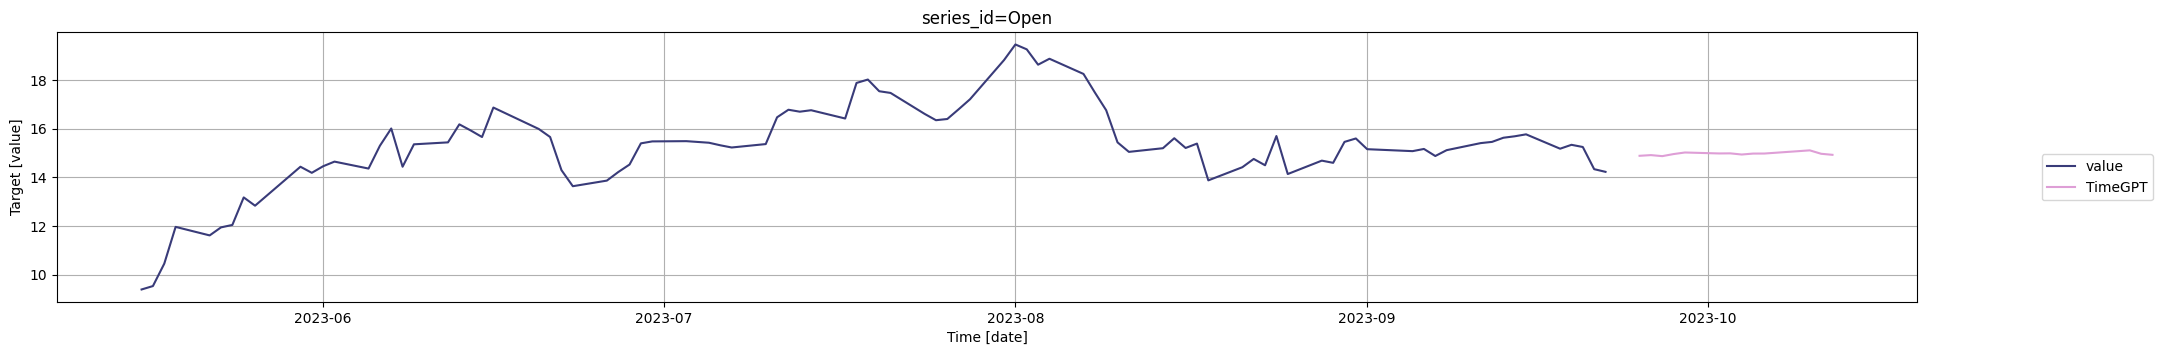

In [24]:
nixtla_client.plot(
    pltr_long_df, 
    fcst_pltr_long_df, 
    id_col='series_id',
    time_col='date',
    target_col='value',
    unique_ids=['Open'],
    max_insample_length=90,
)

#### Adding extra information

In time series forecasting, the variables that we predict are often influenced not just by their past values, but also by other factors or variables. These external variables, known as exogenous variables, can provide vital additional context that can significantly improve the accuracy of our forecasts. One such factor, and the focus of this tutorial, is the company's revenue. Revenue figures can provide a key indicator of a company's financial health and growth potential, both of which can heavily influence its stock price. That we can obtain from `OpenBB`.

In [25]:
revenue_pltr = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/revenue-pltr.csv')

In [26]:
#| hide
value = revenue_pltr['totalRevenue'].iloc[0]
if not isinstance(value, float) and 'M' in value:
    def convert_to_float(val):
        if 'M' in val:
            return float(val.replace(' M', '')) * 1e6
        elif 'K' in val:
            return float(val.replace(' K', '')) * 1e3
        else:
            return float(val)
    revenue_pltr['totalRevenue'] = revenue_pltr['totalRevenue'].apply(convert_to_float)

In [27]:
revenue_pltr.tail()

,fiscalDateEnding,totalRevenue
5,2022-06-30,473010000.0
6,2022-09-30,477880000.0
7,2022-12-31,508624000.0
8,2023-03-31,525186000.0
9,2023-06-30,533317000.0


The first thing we observe in our dataset is that we have information available only up until the end of the first quarter of 2023. Our data is represented in a quarterly frequency, and our goal is to leverage this information to forecast the daily stock prices for the next 14 days beyond this date.

However, to accurately compute such a forecast that includes the revenue as an exogenous variable, we need to have an understanding of the future values of the revenue. This is critical because these future revenue values can significantly influence the stock price. 

Since we're aiming to predict 14 daily stock prices, we only need to forecast the revenue for the upcoming quarter. This approach allows us to create a cohesive forecasting pipeline where the output of one forecast (revenue) is used as an input to another (stock price), thereby leveraging all available information for the most accurate predictions possible.



In [28]:
fcst_pltr_revenue = nixtla_client.forecast(revenue_pltr, h=1, time_col='fiscalDateEnding', target_col='totalRevenue')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: Q-DEC
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [29]:
fcst_pltr_revenue.head()

,fiscalDateEnding,TimeGPT
0,2023-09-30,547264448


Continuing from where we left off, the next crucial step in our forecasting pipeline is to adjust the frequency of our data to match the stock prices' frequency, which is represented on a business day basis. To accomplish this, we need to resample both the historical and future forecasted revenue data.

We can achieve this using the following code

In [30]:
revenue_pltr['fiscalDateEnding'] = pd.to_datetime(revenue_pltr['fiscalDateEnding'])
revenue_pltr = revenue_pltr.set_index('fiscalDateEnding').resample('B').ffill().reset_index()

**IMPORTANT NOTE**: It's crucial to highlight that in this process, we are assigning the same revenue value to all days within the given quarter. This simplification is necessary due to the disparity in granularity between quarterly revenue data and daily stock price data. However, it's vital to treat this assumption with caution in practical applications. The impact of quarterly revenue figures on daily stock prices can vary significantly within the quarter based on a range of factors, including changing market expectations, other financial news, and events. In this tutorial, we use this assumption to illustrate the process of incorporating exogenous variables into our forecasting model, but in real-world scenarios, a more nuanced approach may be needed, depending on the available data and the specific use case.

Then we can create the full historic dataset.

In [31]:
pltr_revenue_df = pltr_df.merge(revenue_pltr.rename(columns={'fiscalDateEnding': 'date'}))

In [32]:
pltr_revenue_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,totalRevenue
0,2021-03-31,22.500000,23.850000,22.379999,23.290001,23.290001,61458500,0.0,0.0,341234000.0
1,2021-04-01,23.950001,23.950001,22.730000,23.070000,23.070000,51788800,0.0,0.0,341234000.0
2,2021-04-05,23.780001,24.450001,23.340000,23.440001,23.440001,65374300,0.0,0.0,341234000.0
3,2021-04-06,23.549999,23.610001,22.830000,23.270000,23.270000,41933500,0.0,0.0,341234000.0
4,2021-04-07,23.000000,23.549999,22.809999,22.900000,22.900000,32766200,0.0,0.0,341234000.0


To calculate the dataframe of the future revenue:

In [33]:
horizon = 14

In [34]:
import numpy as np

In [35]:
future_df = pd.DataFrame({
    'date': pd.date_range(pltr_revenue_df['date'].iloc[-1], periods=horizon + 1, freq='B')[-horizon:],
    'totalRevenue': np.repeat(fcst_pltr_revenue.iloc[0]['TimeGPT'], horizon)
})

In [36]:
future_df.head()

,date,totalRevenue
0,2023-07-03,547264448
1,2023-07-04,547264448
2,2023-07-05,547264448
3,2023-07-06,547264448
4,2023-07-07,547264448


And then we can pass the future revenue in the `forecast` method using the `X_df` argument. Since the revenue is in the historic dataframe, that information will be used in the model.

In [37]:
fcst_pltr_df = nixtla_client.forecast(
    pltr_revenue_df, h=horizon, 
    freq='B',
    time_col='date', 
    target_col='Close',
    X_df=future_df,
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: totalRevenue
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


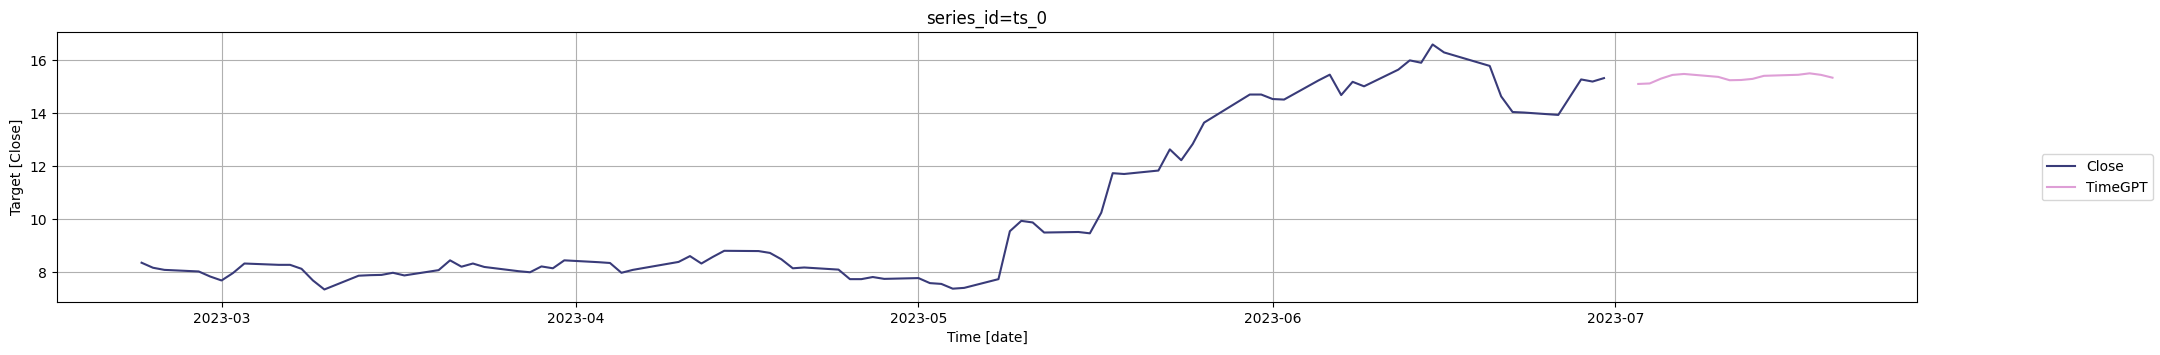

In [38]:
nixtla_client.plot(
    pltr_revenue_df, 
    fcst_pltr_df, 
    id_col='series_id',
    time_col='date',
    target_col='Close',
    max_insample_length=90,
)

We can also see the importance of the revenue:

<Axes: ylabel='features'>

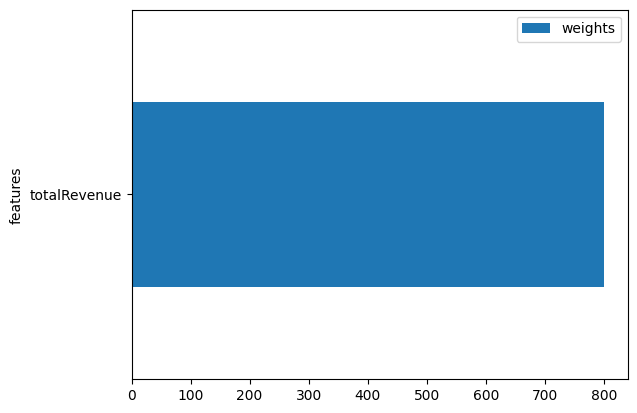

In [39]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

From the feature importance plot, we can conclude that the revenue is an important factor in the model's predictions, meaning changes in revenue will impact the forecast outcome. 